In [22]:
import numpy as np
from scipy.io import wavfile
from python_speech_features import mfcc
import os
import matplotlib.pyplot as plt
import math

blues
blues done
classical
classical done
country
country done
disco
disco done
hiphop
hiphop done
jazz
jazz done
metal
metal done
pop
pop done
reggae
reggae done
rock
rock done


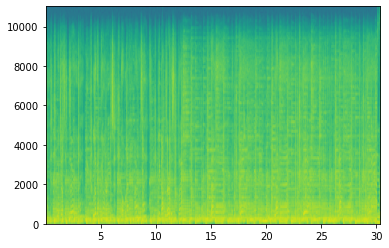

In [17]:
nfft = 300
resize = (151, 3840)

def openGenreTrainSongs(genreName):
    output = []
    print(genreName)
    for fileName in os.listdir(os.getcwd() + "/../data/train/" + genreName):
        sampleRate, samples = wavfile.read(os.getcwd() + "/../data/train/" + genreName + "/" + fileName)
        spectrum, f, t, im = plt.specgram(samples, Fs=sampleRate, NFFT=nfft) # normalize?
#         print(spectrum.shape)
#         break
        spectrum = 10. * np.log10(spectrum)
        spectrogram = np.resize(spectrum, resize) # some of the songs have a few extra samples and such so normalize it to 2900
        output.append(spectrogram.flatten()) # flatten into a vector for pca
        
        
    print(genreName + " done")
    return output

allTraining = []
bluesTraining = openGenreTrainSongs("blues")
classicalTraining = openGenreTrainSongs("classical")
countryTraining = openGenreTrainSongs("country")
discoTraining = openGenreTrainSongs("disco")
hiphopTraining = openGenreTrainSongs("hiphop")
jazzTraining = openGenreTrainSongs("jazz")
metalTraining = openGenreTrainSongs("metal")
popTraining = openGenreTrainSongs("pop")
reggaeTraining = openGenreTrainSongs("reggae")
rockTraining = openGenreTrainSongs("rock")
allTraining = bluesTraining + classicalTraining + countryTraining + discoTraining + hiphopTraining + jazzTraining + metalTraining + popTraining + reggaeTraining + rockTraining

In [46]:
resize = (2990, 13)
def openGenreTrainSongs(genreName):
    output = []
    print(genreName)
    for fileName in os.listdir(os.getcwd() + "/../data/train/" + genreName):
        sampleRate, samples = wavfile.read(os.getcwd() + "/../data/train/" + genreName + "/" + fileName)
        mel = mfcc(samples, sampleRate, winlen=0.02, appendEnergy=False)
        mel = np.resize(mel, resize).flatten()
        output.append(mel) # flatten into a vector for pca
        
        
    print(genreName + " done")
    return output

allTraining = []
bluesTraining = openGenreTrainSongs("blues")
classicalTraining = openGenreTrainSongs("classical")
countryTraining = openGenreTrainSongs("country")
discoTraining = openGenreTrainSongs("disco")
hiphopTraining = openGenreTrainSongs("hiphop")
jazzTraining = openGenreTrainSongs("jazz")
metalTraining = openGenreTrainSongs("metal")
popTraining = openGenreTrainSongs("pop")
reggaeTraining = openGenreTrainSongs("reggae")
rockTraining = openGenreTrainSongs("rock")
allTraining = bluesTraining + classicalTraining + countryTraining + discoTraining + hiphopTraining + jazzTraining + metalTraining + popTraining + reggaeTraining + rockTraining

blues
blues done
classical
classical done
country
country done
disco
disco done
hiphop
hiphop done
jazz
jazz done
metal
metal done
pop
pop done
reggae
reggae done
rock
rock done


In [39]:
A = np.matrix(np.dstack(allTraining).squeeze())
mean = np.mean(A, axis=1)
A -= mean # centre data around the mean

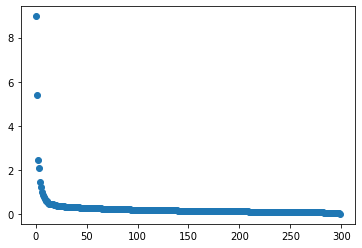

In [40]:
covar = A.T.dot(A) # covariance matrix to reduce size

eVal, eVec = np.linalg.eig(covar)
sortIndex = np.argsort(eVal)[::-1]
eVec = eVec[:, sortIndex]
eVal = eVal[sortIndex]

plt.scatter(np.arange(300), eVal)
plt.show()

In [41]:
principleComponents = []
for ev in range(eVec.shape[1]):
    pc = A * eVec[:, ev] # project back up to normal song space
    pc /= np.sqrt((pc.T.dot(pc))[0,0]) # normalize the principle component vectors
    principleComponents.append(pc)

(300, 300)


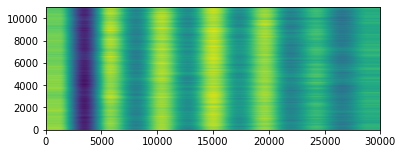

In [42]:
thing = np.resize(principleComponents[0], resize)
extent = 0, 30000, 0, 11025
plt.imshow(thing, origin="upper", extent=extent, vmin=None, vmax=None)
print(eVec.shape)

In [44]:
def getGenreWeights(genreTrainingSet, pcs):
    weights = []
    for song in genreTrainingSet:
        s = np.resize(song, (song.shape[0], 1))
        s -= mean
        w = pcs.dot(s)
        weights.append(w)
    return weights


numberOfPCs = 50

componentsToUse = np.array(principleComponents[:numberOfPCs]).squeeze()



bluesWeights = getGenreWeights(bluesTraining, componentsToUse)
classicalWeights = getGenreWeights(classicalTraining, componentsToUse)
countryWeights = getGenreWeights(countryTraining, componentsToUse)
discoWeights = getGenreWeights(discoTraining, componentsToUse)
hiphopWeights = getGenreWeights(hiphopTraining, componentsToUse)
jazzWeights = getGenreWeights(jazzTraining, componentsToUse)
metalWeights = getGenreWeights(metalTraining, componentsToUse)
popWeights = getGenreWeights(popTraining, componentsToUse)
reggaeWeights = getGenreWeights(reggaeTraining, componentsToUse)
rockWeights = getGenreWeights(rockTraining, componentsToUse)

blues: 12/70


/home/davis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


classical: 7/70
country: 0/70
disco: 0/70
hiphop: 28/70
jazz: 1/70
metal: 55/70
pop: 66/70
reggae: 0/70
rock: 1/70


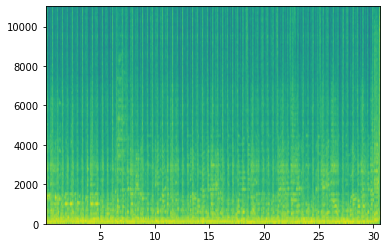

In [20]:
def genreKNN(testWeights, genreWeights, genreName, neighbours):
    for songWeights in genreWeights:
        distance = np.sqrt(np.sum(np.square(testWeights - songWeights)))
        maxCurrentNeighbour = neighbours.index(max(neighbours, key=lambda x:x[1]))
        if(distance < neighbours[maxCurrentNeighbour][1]):
            neighbours[maxCurrentNeighbour] = (genreName, distance)

    return neighbours  


def testGenre(kNeighbours, genreName):
    successes = 0
    total = 0
    neighbours = [("not set", math.inf) for i in range(kNeighbours)]  
    for fileName in os.listdir(os.getcwd() + "/../data/test/" + genreName):
        sampleRate, samples = wavfile.read(os.getcwd() + "/../data/test/" + genreName + "/" + fileName)
        spectrum, f, t, im = plt.specgram(samples, Fs=sampleRate, NFFT=nfft)
        spectrum = 10. * np.log10(spectrum)
        testSpec = np.resize(spectrum, resize).flatten()
        testSpec = np.resize(testSpec, (testSpec.shape[0], 1))
        testSpec -= mean
        testWeights = componentsToUse.dot(testSpec)

        neighbours = genreKNN(testWeights, bluesWeights, "blues", neighbours)
        neighbours = genreKNN(testWeights, classicalWeights, "classical", neighbours)
        neighbours = genreKNN(testWeights, countryWeights, "country", neighbours)
        neighbours = genreKNN(testWeights, discoWeights, "disco", neighbours)
        neighbours = genreKNN(testWeights, hiphopWeights, "hiphop", neighbours)
        neighbours = genreKNN(testWeights, jazzWeights, "jazz", neighbours)
        neighbours = genreKNN(testWeights, metalWeights, "metal", neighbours)
        neighbours = genreKNN(testWeights, popWeights, "pop", neighbours)
        neighbours = genreKNN(testWeights, reggaeWeights, "reggae", neighbours)
        neighbours = genreKNN(testWeights, rockWeights, "rock", neighbours)
        neighboursGenres = [x[0] for x in neighbours]
        
        prediction = max(set(neighboursGenres), key=neighboursGenres.count)
        if(prediction == genreName):
            successes += 1
        total += 1

    print(genreName + ": " + str(successes) + "/" + str(total))

    



kNeighbours = 5
testGenre(kNeighbours, "blues")
testGenre(kNeighbours, "classical")
testGenre(kNeighbours, "country")
testGenre(kNeighbours, "disco")
testGenre(kNeighbours, "hiphop")
testGenre(kNeighbours, "jazz")
testGenre(kNeighbours, "metal")
testGenre(kNeighbours, "pop")
testGenre(kNeighbours, "reggae")
testGenre(kNeighbours, "rock")

In [47]:
def genreKNN(testWeights, genreWeights, genreName, neighbours):
    for songWeights in genreWeights:
        distance = np.sqrt(np.sum(np.square(testWeights - songWeights)))
        maxCurrentNeighbour = neighbours.index(max(neighbours, key=lambda x:x[1]))
        if(distance < neighbours[maxCurrentNeighbour][1]):
            neighbours[maxCurrentNeighbour] = (genreName, distance)

    return neighbours  


def testGenre(kNeighbours, genreName):
    successes = 0
    total = 0
    neighbours = [("not set", math.inf) for i in range(kNeighbours)]  
    for fileName in os.listdir(os.getcwd() + "/../data/test/" + genreName):
        sampleRate, samples = wavfile.read(os.getcwd() + "/../data/test/" + genreName + "/" + fileName)
        testMel = mfcc(samples, sampleRate, winlen=0.02, appendEnergy=False)
        testMel = np.resize(testMel, resize).flatten()
        testMel = np.resize(testMel, (testMel.shape[0], 1))
        testMel -= mean
        testWeights = componentsToUse.dot(testMel)

        neighbours = genreKNN(testWeights, bluesWeights, "blues", neighbours)
        neighbours = genreKNN(testWeights, classicalWeights, "classical", neighbours)
        neighbours = genreKNN(testWeights, countryWeights, "country", neighbours)
        neighbours = genreKNN(testWeights, discoWeights, "disco", neighbours)
        neighbours = genreKNN(testWeights, hiphopWeights, "hiphop", neighbours)
        neighbours = genreKNN(testWeights, jazzWeights, "jazz", neighbours)
        neighbours = genreKNN(testWeights, metalWeights, "metal", neighbours)
        neighbours = genreKNN(testWeights, popWeights, "pop", neighbours)
        neighbours = genreKNN(testWeights, reggaeWeights, "reggae", neighbours)
        neighbours = genreKNN(testWeights, rockWeights, "rock", neighbours)
        neighboursGenres = [x[0] for x in neighbours]
        
        prediction = max(set(neighboursGenres), key=neighboursGenres.count)
        if(prediction == genreName):
            successes += 1
        total += 1

    print(genreName + ": " + str(successes) + "/" + str(total))

    



kNeighbours = 5
testGenre(kNeighbours, "blues")
testGenre(kNeighbours, "classical")
testGenre(kNeighbours, "country")
testGenre(kNeighbours, "disco")
testGenre(kNeighbours, "hiphop")
testGenre(kNeighbours, "jazz")
testGenre(kNeighbours, "metal")
testGenre(kNeighbours, "pop")
testGenre(kNeighbours, "reggae")
testGenre(kNeighbours, "rock")

blues: 0/70
classical: 37/70


KeyboardInterrupt: 